# **Linear Regression Model**

## **Fisrt Steps**

In [347]:
# Set imports
import pandas
import numpy
import seaborn
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score


In [348]:
# Set Variables
data_path = '../assets/data_filtered.csv'

selected_item = 'FZ150'
time_frequencies = ['D', '3D', 'W', '3W', 'ME', '3ME']
time_frequency_preview = 'ME'
model_random_seed = 42

show_plots = False

#### Set Functions

In [349]:
class Struct:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            if isinstance(value, dict):
                self.__dict__[key] = Struct(**value)
            else:
                self.__dict__[key] = value

In [350]:
def plotter(xy, title, y_limit, grid):
   
   dataframe = xy.copy()
   dataframe['fecha_ordinal'] = dataframe['fecha'].map(pandas.Timestamp.toordinal)
   time = numpy.asarray(dataframe['fecha'], dtype='datetime64[s]')

   coef = numpy.polyfit(dataframe['fecha_ordinal'], dataframe[selected_item], 1)
   poly1d_fn = numpy.poly1d(coef)  # Obtener la función polinómica de grado 1

   figure, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(10, 3))

   ax = axes
   ax.scatter(time, dataframe[selected_item], s=12, label=selected_item)
   ax.plot(time, poly1d_fn(dataframe['fecha_ordinal']), color='purple', label='Tendencia lineal')
   ax.tick_params(axis='x', labelrotation=0)
   ax.margins(x=0.03, y=0.04)
   ax.set(
      title='  |  '.join(title),
      xlabel='Fecha', 
      ylabel='No. de Ventas',
      ylim=y_limit
   )
   ax.legend()
   if grid: 
      ax.grid()

   figure.tight_layout()

In [351]:
def standart_deviation_filter(data, value):
   media = data[value].mean()
   desv_std = data[value].std()
   rango_valido = [media - 3 * desv_std, media + 3 * desv_std]

   # Filtrar datos dentro del rango válido
   return data[(data[value] >= rango_valido[0]) & (data[value] <= rango_valido[1])]

In [352]:
def quantiles_filter(data, value):
   # Límites basados en cuartiles
   Q1 = data[value].quantile(0.25)
   Q3 = data[value].quantile(0.75)
   IQR = Q3 - Q1
   rango_valido = [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]
   rango_valido_min = rango_valido[0]
   rango_valido_max = rango_valido[1]

   # Filtrar datos dentro del rango válido
   return data[(data[value] >= rango_valido_min) & (data[value] <= rango_valido_max)]

In [353]:
def linear_regression(data_x, data_y):
   model = LinearRegression()

   # Dividir los datos en conjuntos de entrenamiento y prueba
   X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, train_size=0.8, test_size=0.2, random_state=model_random_seed)

   # Crear y entrenar el modelo
   model.fit(X_train, y_train)
   
   # Realizar predicciones en el conjunto de prueba
   y_pred = model.predict(X_test)

   # Calcular el MSE y el R^2
   data_min = data_y.min()
   data_max = data_y.max()

   ecm = mean_squared_error(y_test, y_pred)
   recm = root_mean_squared_error(y_test, y_pred)
   precm = recm / (data_max - data_min) * 100

   r2 = r2_score(y_test, y_pred)
   pr2 = r2 * 100

   data_trainig = {
      'x_test': X_test,
      'x_train': X_train,
      'y_test': y_test,
      'y_train': y_train,
      'y_pred': y_pred
   }
   results = {
      'range': (data_min, data_max),

      'ecm': ecm,
      'recm': recm,
      'precm': precm,

      'r2': r2, 
      'pr2': pr2
   }

   return Struct(**{
      'model': model,
      'training': data_trainig,
      'results': results
   })

In [354]:
def frequency_spliter(data):
   data_splitted = {}
   
   for frequency in time_frequencies:
      data_metadata = {}

      frequency_data = data.groupby(pandas.Grouper(key='fecha', freq=frequency, sort=True)).sum().reset_index() if frequency != 'D' else data.copy()

      # Ennumerate data
      date_reference = frequency_data['fecha'].min()
      frequency_data['dia'] = (frequency_data['fecha'] - date_reference).dt.days + 1
      # freq_data['dia'] = freq_data['fecha'] = range(1, len(freq_data) + 1)

      # freq_data.insert(1, 'dia', (freq_data['fecha'].dt.to_period('D') + 1 - freq_data['fecha'].dt.to_period('D').min()).apply(lambda x: x.n))
      # freq_data.insert(1, 'mes', (freq_data['fecha'].dt.to_period('M') + 1 - freq_data['fecha'].dt.to_period('M').min()).apply(lambda x: x.n))
      # freq_data.insert(1, 'año', (freq_data['fecha'].dt.to_period('Y') + 1 - freq_data['fecha'].dt.to_period('Y').min()).apply(lambda x: x.n))

      data_min = frequency_data[selected_item].min()
      data_max = frequency_data[selected_item].max()
      range_diff = (data_max - data_min) / 20
      range_min = -range_diff if data_min <= 0 else 0

      data_metadata['dataset'] = frequency_data
      data_metadata['time'] = numpy.asarray(frequency_data['fecha'], dtype='datetime64[s]')
      data_metadata['range'] = (range_min, data_max + range_diff)

      data_splitted[frequency] = Struct(**data_metadata)
   
   return data_splitted

## **Prepare Data**

In [355]:
# Load and prepare Dataset
datos = pandas.read_csv(data_path, parse_dates=['fecha'], date_format='%Y-%m-%d')

In [356]:
# Set Independent Data
items = list( datos.iloc[:, 1:-1].keys() )
independent_data = ['dia']

In [357]:
# Filter data by time-frequencies
data = frequency_spliter(data=datos)

In [358]:
# Prepare data example to plot
data_example = data[time_frequency_preview]
show_plot_grids = True

## **Out Atypical Data Filter**

In [359]:
# Filter data removing Out atypical (extreme) values

# Stardart deviation limits
st_dev_data = standart_deviation_filter(data=data_example.dataset, value=selected_item)
st_dev_time = numpy.asarray(st_dev_data['fecha'], dtype='datetime64[s]')

# Quantiles limits
quant_data = quantiles_filter(data=data_example.dataset, value=selected_item)
quant_time = numpy.asarray(quant_data['fecha'], dtype='datetime64[s]')

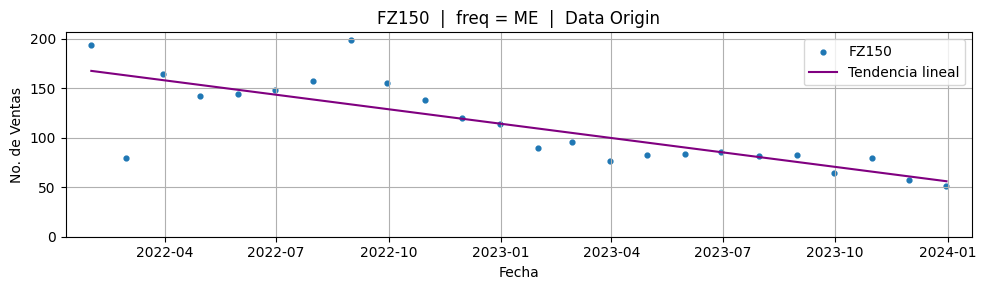

In [360]:
# Example data plot
# if show_plots:
plotter(
   xy=data_example.dataset[['fecha' ,selected_item]], 
   title=[selected_item, f'freq = {time_frequency_preview}', 'Data Origin'], 
   y_limit=data_example.range,
   grid=show_plot_grids,
)

In [361]:
# Stardart Deviation plot
if show_plots:
   plotter(
      xy=st_dev_data[['fecha' ,selected_item]], 
      title=[selected_item, f'freq = {time_frequency_preview}', 'Filtrado de Datos Atípicos (Desviación Estandar)'], 
      y_limit=data_example.range,
      grid=show_plot_grids,
   )

In [362]:
# Quantiles plot
if show_plots:
   plotter(
      xy=quant_data[['fecha' ,selected_item]], 
      title=[selected_item, f'freq = {time_frequency_preview}', 'Filtrado de Datos Atípicos (Cuantiles)'], 
      y_limit=data_example.range,
      grid=show_plot_grids,
   )

In [363]:
# Limits comparison plot
if show_plots:
   figure, axes = pyplot.subplots(ncols=3, figsize=(10, 4.5))

   ax = axes[0]
   ax.boxplot(data_example.dataset[selected_item], showfliers=False)
   ax.scatter(x=[.8] * len(data_example.dataset), y=data_example.dataset[selected_item], alpha=0.3, s=24)
   ax.grid()
   ax.set(
      title='Ventas  |  Original Data',
      ylabel=selected_item,
      ylim=data_example.range,
      xticks=([])
   )

   ax = axes[1]
   ax.boxplot(st_dev_data[selected_item], showfliers=False)
   ax.scatter(x=[.8] * len(st_dev_data), y=st_dev_data[selected_item], alpha=0.3, s=24)
   ax.grid()
   ax.set(
      title='Ventas  |  Desv. Estándar',
      ylim=data_example.range,
      xticks=([])
   )

   ax = axes[2]
   ax.boxplot(quant_data[selected_item], showfliers=True)
   ax.scatter(x=[.8] * len(quant_data), y=quant_data[selected_item], alpha=0.3, s=24)
   ax.grid()
   ax.set(
      title='Ventas  |  Lim. Cuantiles',
      ylim=data_example.range,
      xticks=([])
   )


In [364]:
# Data example histogram
if show_plots:
   histogram_plot = pandas.DataFrame(data_example.dataset[selected_item])

   fig, ax = pyplot.subplots(figsize=(9.8, 3.5))

   seaborn.histplot(histogram_plot, 
      x=selected_item, 
      bins=20, 
      kde=True, 
      kde_kws = {'bw_adjust': .7}
   ).lines[0].set_color('blue')

## **Model Train and Test**

In [365]:
# Example data - Run Model
data_example = data[time_frequency_preview].dataset
data_example_model = linear_regression(
   data_x=data_example[independent_data], 
   data_y=data_example[selected_item]
)
data_example[['dia', selected_item]].head()

,dia,FZ150
0,1,194
1,29,79
2,60,164
3,90,142
4,121,144


In [366]:
# Example data - Results
data_example_training = data_example_model.training
data_example_predict = data_example_training.y_pred
with numpy.nditer(data_example_predict, op_flags=['readwrite']) as it:
   for x in it:
      x[...] = f'{x:.0f}'
data_example_predict = pandas.DataFrame({ 'pred': data_example_predict }, index=list(data_example_training.y_test.index))

df_merged = pandas.concat([
   data_example_training.x_test, 
   data_example_training.y_test,
   data_example_predict
], axis=1, join='inner')
df_merged.rename(columns={selected_item: 'real'})
df_merged.head(10)


,dia,FZ150,pred
8,243,155,125.0
16,486,84,90.0
0,1,194,160.0
18,547,82,81.0
11,335,114,111.0


In [367]:
# Example data - Model Results
data_example_results = data_example_model.results

print(f'Item: {selected_item}')
print(f'Freq: {time_frequency_preview}\n')
print(f'Range: {data_example_results.range}') # Selected Item Value Ranges

# print(f'MSE: {data_example_results.ecm}') # Error Cuadrático Medio
print(f'RECM: ± {data_example_results.recm:.0f}') # Raíz del Error Cuadrático Medio
print(f'RECM(%): {data_example_results.precm:.2f} %') # Porcentaje de la Raíz del Error Cuadrático Medio

# print(f'R^2: {data_example_results.r2}') # R-Cuadrado (ajuste del modelo)
print(f'R^2(%): {data_example_results.pr2:.2f} %') # Porcentaje de R-Cuadrado

Item: FZ150
Freq: ME

Range: (51, 199)
RECM: ± 21
RECM(%): 13.96 %
R^2(%): 77.07 %


## **Run Model**

In [368]:
# Results mappers
rmse_results = {
   'Orig. Range': [],
   'Orig.': [], 
   'Stand. Dev. Range': [],
   'Stand. Dev.': [], 
   'Quant. Range': [],
   'Quant.': [],
}

prmse_results = {
   'Orig.': [],
   'Stand. Dev.': [],
   'Quant.': [],
}

pr2_results = {
   'Orig.': [],
   'Stand. Dev.': [], 
   'Quant.': [],
}

In [369]:
# Run model by freq and limit filter
for freq in time_frequencies:

   # Original data
   data_model = linear_regression(data_x=data[freq].dataset[independent_data], data_y=data[freq].dataset[selected_item])
   data_model_results = data_model.results

   rmse_results['Orig. Range'].append( f'{data_model_results.range}' )
   rmse_results['Orig.'].append( f'{data_model_results.recm:.0f}' )
   prmse_results['Orig.'].append( f'{data_model_results.precm:.1f}%' )
   pr2_results['Orig.'].append( f'{data_model_results.pr2:.0f}%' )

   # Standart deviation data
   st_dev_data = standart_deviation_filter(data=data[freq].dataset, value=selected_item)
   st_dev_model = linear_regression(data_x=st_dev_data[independent_data], data_y=st_dev_data[selected_item])
   st_dev_model_results = st_dev_model.results

   rmse_results['Stand. Dev. Range'].append( f'{st_dev_model_results.range}' )
   rmse_results['Stand. Dev.'].append( f'{st_dev_model_results.recm:.0f}' )
   prmse_results['Stand. Dev.'].append( f'{st_dev_model_results.precm:.1f}%' )
   pr2_results['Stand. Dev.'].append( f'{st_dev_model_results.pr2:.0f}%' )

   # Quantiles data
   quant_data = standart_deviation_filter(data=data[freq].dataset, value=selected_item)
   quant_model = linear_regression(data_x=quant_data[independent_data], data_y=quant_data[selected_item])
   quant_model_results = quant_model.results
   rmse_results['Quant. Range'].append( f'{quant_model_results.range}' )
   rmse_results['Quant.'].append( f'{quant_model_results.recm:.0f}' )
   prmse_results['Quant.'].append( f'{quant_model_results.precm:.1f}%' )
   pr2_results['Quant.'].append( f'{quant_model_results.pr2:.0f}%' )

In [370]:
# Show RMSE results
General_RMSE_Results = pandas.DataFrame(rmse_results, index=time_frequencies)
# General_RMSE_Results

In [371]:
# Show RMSE (%) results
General_PRMSE_Results = pandas.DataFrame(prmse_results, index=time_frequencies)
General_PRMSE_Results

,Orig.,Stand. Dev.,Quant.
D,15.7%,21.3%,21.3%
3D,17.2%,22.6%,22.6%
W,15.1%,13.5%,13.5%
3W,13.5%,13.5%,13.5%
ME,14.0%,14.0%,14.0%
3ME,3.4%,3.4%,3.4%


In [372]:
# Show R2 results
General_R2_Results = pandas.DataFrame(pr2_results, index=time_frequencies)
General_R2_Results

,Orig.,Stand. Dev.,Quant.
D,13%,14%,14%
3D,7%,-27%,-27%
W,41%,45%,45%
3W,63%,63%,63%
ME,77%,77%,77%
3ME,97%,97%,97%


## **Model Predictions**

In [373]:
# Final prediction
selected_data = data[time_frequency_preview].dataset.copy()

In [374]:
selected_data[['fecha', 'dia', selected_item]].head()

,fecha,dia,FZ150
0,2022-01-31,1,194
1,2022-02-28,29,79
2,2022-03-31,60,164
3,2022-04-30,90,142
4,2022-05-31,121,144


In [375]:
selected_data[['fecha', 'dia', selected_item]].tail()

,fecha,dia,FZ150
19,2023-08-31,578,83
20,2023-09-30,608,64
21,2023-10-31,639,80
22,2023-11-30,669,57
23,2023-12-31,700,51


In [376]:
# Training Model
selected_lineal_regression = linear_regression(
   data_x=selected_data[independent_data], 
   data_y=selected_data[selected_item]
)
selected_data_model = selected_lineal_regression.model

In [377]:
# Set future dates to predict
date_references = [selected_data['fecha'].min(), selected_data['fecha'].max()]

future_dates = pandas.date_range(date_references[1], periods=6, freq=time_frequency_preview)
data_future_dates = pandas.DataFrame({'fecha': future_dates})
data_future_dates['dia'] = (data_future_dates['fecha'] - date_references[0]).dt.days + 1

data_predictions = data_future_dates.iloc[1:].reset_index()[['fecha', 'dia']]
# data_predictions

In [378]:
# Final Results
predictions = list( selected_data_model.predict(data_predictions[['dia']]) )
# predictions = list(map(int, predictions))
predictions = [round(x) for x in predictions]

data_predictions['predictions'] = pandas.DataFrame({ 'predictions': predictions })
data_predictions

,fecha,dia,predictions
0,2024-01-31,731,54
1,2024-02-29,760,50
2,2024-03-31,791,45
3,2024-04-30,821,41
4,2024-05-31,852,37
